In [1]:
import pandas as pd, numpy as np, seaborn as sns
from pprint import pprint
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import math
from collections import Counter

import datetime, time

from pprint import pprint
import re

In [2]:
def printRuntime():
    print(datetime.datetime.now().strftime("%Y-%m-%d %T"))
    print("-"*19)
printRuntime()

2020-02-25 21:15:16
-------------------


# 1. Load data

In [3]:
basePath = "./kalapa/"
trainPath = basePath + "train.csv"
testPath = basePath + "test.csv"
colDesc = basePath + "column_description.csv"
sampleSubmit = basePath + "sample_submission.csv"

cleanedTrain = basePath + "cleanedTrain.pickle"
cleanedTest = basePath + "cleanedTest.pickle"
nb01 = basePath + "nb01.pickle"
nb02 = basePath + "nb02.pickle"
nb03 = basePath + "nb03.pickle"
printRuntime()

2020-02-25 21:15:16
-------------------


In [4]:
def avgAge(row):
    a = row["age_source1"]
    b = row["age_source2"]
    if np.isnan(a) and np.isnan(b):
        return np.nan
    elif np.isnan(a):
        return b
    elif np.isnan(b):
        return a
    else:
        return (a+b)/2.0
    
def diffAge(row):
    a = row["age_source1"]
    b = row["age_source2"]
    if np.isnan(a) and np.isnan(b):
        return np.nan
    elif np.isnan(a):
        return -b
    elif np.isnan(b):
        return a
    else:
        return (a+b)/2.0
    
def groupAge(age):
    # 18-23; 23-35; 35-50; 50+
    result = ""
    if np.isnan(age):
        result = "AGE_NONE"
    elif age <= 18:
        result = "AGE_0"
    elif age <=23:
        result = "AGE_1"
    elif age <=35:
        result = "AGE_2"
    elif age <= 50:
        result = "AGE_3"
    else:
        result = "AGE_4"
    return result
printRuntime()

2020-02-25 21:15:17
-------------------


# Train

In [5]:
pdfTrainRaw = pd.read_csv(trainPath)
printRuntime()

2020-02-25 21:15:18
-------------------


/Users/newuser/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
cond = (
    ~((pdfTrainRaw["age_source1"]<18) | (pdfTrainRaw["age_source2"]<18)) # Filter out age < 18, keep NaN
)
# pdfTrain = pdfTrainRaw[cond].copy()
pdfTrain = pdfTrainRaw.copy()
pdfTrain["maCv"] = pdfTrain["maCv"].apply(lambda x: str(x).lower())
pdfTrain["province"] = pdfTrain["province"].apply(lambda x: str(x).lower())
pdfTrain["district"] = pdfTrain["district"].apply(lambda x: str(x).lower())
print(pdfTrain.shape)
printRuntime()

(30000, 64)
2020-02-25 21:15:18
-------------------


In [7]:
lsMetaCol = ["id", "label", "province", "district", "age_source1", "age_source2", "maCv"]

# Test

In [8]:
pdfTestRaw = pd.read_csv(testPath)
printRuntime()

2020-02-25 21:15:19
-------------------


/Users/newuser/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
cond = (
    ~((pdfTestRaw["age_source1"]<18) | (pdfTestRaw["age_source2"]<18)) # Filter out age < 18, keep NaN
)
# pdfTest = pdfTestRaw[cond].copy()
pdfTest = pdfTestRaw.copy()
pdfTest["maCv"] = pdfTest["maCv"].apply(lambda x: str(x).lower())
pdfTest["province"] = pdfTest["province"].apply(lambda x: str(x).lower())
pdfTest["district"] = pdfTest["district"].apply(lambda x: str(x).lower())
print(pdfTest.shape)
printRuntime()

(20000, 63)
2020-02-25 21:15:20
-------------------


### Clean data

In [ ]:
25, 29, 30, 31, 36, 37, : 'TRUE' -> True, 'FALSE' -> False !DONE
35: => "Zero"-"Four" -> 1-5 scale (with NULL) !DONE
41: "I"-"V" -> 1-5 scale (with NULL) !DONE
42, 44: "Zezo", "One", "Two" !DONE
45: "1" 1.0 -> 1; "2" 2.0 ->2 !DONE

### Break down maCv to (maCv[:2] + maCv[2:])

In [10]:
def formatJob(iStr):
    if "none" == iStr or "nan" == iStr:
        return "none"
    # Replace all digit
    iStr = re.sub("\d", "", iStr)
    # Replace cn to cong nhan
    iStr = re.sub(r"^(cnhân|cn|coõng nhaõn)", "công nhân ", iStr)
    # Replace nv/nv. to nhan vien
    iStr = re.sub(r"(- nv|nv.|nv)", "nhân viên ", iStr)
    # Replace p. to phó
    iStr = re.sub(r"(^p\.)", "phó ", iStr)
    
    iStr = (iStr.replace("-", " ")
            .replace("cty", "công ty")
            .replace(".", " ")
            .replace("(", " ").
            replace(")", " ")
           )
    return iStr

def splitJobType(iStr):
    if "none" == iStr or "nan" == iStr:
        return "none", "none"
    iStr = formatJob(iStr)
    
    lsWord = iStr.split()
    if len(lsWord) == 0:
        return "none", "none"
    splitIdx = 2
    if "phó chánh" in iStr or ("phó trưởng" in iStr 
                               and "phó trưởng phòng" not in iStr
                               and "phó trưởng ban" not in iStr):
        splitIdx = 4
    elif ("phó phòng" not in iStr) and (lsWord[0] == "phó" or lsWord[0] == "trưởng"):
        splitIdx = 3
    
    jobCat = " ".join(lsWord[:splitIdx])
    jobDesc = "none"
    if len(lsWord) > splitIdx:
        jobDesc = " ".join(lsWord[splitIdx:])
    return jobCat, jobDesc

# Test
print(splitJobType("nhân viên phòng thí nghiệm"))
print(splitJobType("nhân viên bảo trì"))
print(splitJobType("cn ủi"))
print(splitJobType("9782cấp dưỡng"))
print(splitJobType("trưởng dây chuyền phòng sản xuất"))
print(splitJobType("p. trưởng phòng"))
printRuntime()

('nhân viên', 'phòng thí nghiệm')
('nhân viên', 'bảo trì')
('công nhân', 'ủi')
('cấp dưỡng', 'none')
('trưởng dây chuyền', 'phòng sản xuất')
('phó trưởng phòng', 'none')
2020-02-25 21:15:24
-------------------


In [11]:
# pdfTrain["jobCat"], pdfTrain["jobDesc"] = pdfTrain["maCv"].apply(lambda x: splitJobType(x))
%time
pdfTrain["maCv"] = pdfTrain["maCv"].apply(formatJob)
pdfTrain["maCv_vector"] = pdfTrain["maCv"].apply(lambda x: x.split())
pdfTrain["jobCat"], pdfTrain["jobDesc"] = zip(*pdfTrain["maCv"].apply(splitJobType))
printRuntime()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
2020-02-25 21:15:24
-------------------


In [12]:
# pdfTest["jobCat"], pdfTest["jobDesc"] = pdfTest["maCv"].apply(lambda x: splitJobType(x))
%time
pdfTest["maCv"] = pdfTest["maCv"].apply(formatJob)
pdfTest["maCv_vector"] = pdfTest["maCv"].apply(lambda x: x.split())
pdfTest["jobCat"], pdfTest["jobDesc"] = zip(*pdfTest["maCv"].apply(splitJobType))
printRuntime()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.25 µs
2020-02-25 21:15:26
-------------------


In [13]:
pdfTrain = (pdfTrain
      .replace(np.nan, "None") # 'None' -> nan
      .replace("TRUE", True) # 'TRUE' -> True
      .replace("FALSE", False) # 'FALSE' -> False
     )

In [14]:
pdfTest = (pdfTest
      .replace(np.nan, "None") # 'None' -> nan
      .replace("TRUE", True) # 'TRUE' -> True
      .replace("FALSE", False) # 'FALSE' -> False
     )

In [15]:
pdfTrainBk = pdfTrain.copy()

pdfTestBk = pdfTest.copy()

#### Replace ilformed values by columns to safely remove

In [16]:
for dfTmp in [pdfTrain, pdfTest]:
    # 6
    dfTmp.loc[dfTmp["FIELD_6"]=="None", "FIELD_6"] = np.nan
    # dfTmp["FIELD_6"] = dfTmp["FIELD_6"] + 1
    
    # 12
    dfTmp.loc[~dfTmp["FIELD_12"].isin(["None", "0", "1"]), "FIELD_12"] = "None"

    # 35 'Four' 'One' 'Three' 'Two'
    dfTmp.loc[dfTmp["FIELD_35"]=="Zero", "FIELD_35"] = 1
    dfTmp.loc[dfTmp["FIELD_35"]=="One", "FIELD_35"] = 2
    dfTmp.loc[dfTmp["FIELD_35"]=="Two", "FIELD_35"] = 3
    dfTmp.loc[dfTmp["FIELD_35"]=="Three", "FIELD_35"] = 4
    dfTmp.loc[dfTmp["FIELD_35"]=="Four", "FIELD_35"] = 5
    
    # 40 
    dfTmp.loc[dfTmp["FIELD_40"].isin(["05 08 11 02", "08 02"]), "FIELD_40"] = "02 05 08 11"
    
    # 41 I II III IV V
    dfTmp.loc[dfTmp["FIELD_41"]=="I", "FIELD_41"] = 1
    dfTmp.loc[dfTmp["FIELD_41"]=="II", "FIELD_41"] = 2
    dfTmp.loc[dfTmp["FIELD_41"]=="III", "FIELD_41"] = 3
    dfTmp.loc[dfTmp["FIELD_41"]=="IV", "FIELD_41"] = 4
    dfTmp.loc[dfTmp["FIELD_41"]=="V", "FIELD_41"] = 5

    # 42
    dfTmp.loc[dfTmp["FIELD_42"]=="Zezo", "FIELD_42"] = 0
    dfTmp.loc[dfTmp["FIELD_42"]=="One", "FIELD_42"] = 1

    # 44
    dfTmp.loc[dfTmp["FIELD_44"]=="One", "FIELD_44"] = 1
    dfTmp.loc[dfTmp["FIELD_44"]=="Two", "FIELD_44"] = 2

    # 45
    dfTmp.loc[(dfTmp["FIELD_45"]=="1")|(dfTmp["FIELD_45"]==1.0), "FIELD_45"] = 1
    dfTmp.loc[(dfTmp["FIELD_45"]=="2")|(dfTmp["FIELD_45"]==2.0), "FIELD_45"] = 2

### One-hot 8 (gender), 10, 12, 17, 24, 40, 43

In [17]:
pdfTrainBk1 = pdfTrain.copy()
pdfTestBk1 = pdfTest.copy()

In [18]:
lsCol = [8, 10, 12, 17, 24, 40, 43]

In [19]:
# Get one hot encoding of columns for pdfTrain pdfTest
for d in lsCol:
    cName = "FIELD_%d" % d
    print(cName)
    one_hot = pd.get_dummies(pdfTrain[cName].replace(np.nan, "None"))
    renameCol = {}
    for c in one_hot.columns:
        renameCol[c] = "%s_%s" % (cName, c)
    # pprint(renameCol)
    one_hot = one_hot.rename(columns=renameCol)
#     pdfTrain = pdfTrain.drop(cName, axis = 1)
    # Join the encoded pdfTrain
    pdfTrain = pdfTrain.join(one_hot)

FIELD_8
FIELD_10
FIELD_12
FIELD_17
FIELD_24
FIELD_40
FIELD_43


In [20]:
for d in lsCol:
    cName = "FIELD_%d" % d
    print(cName)
    one_hot = pd.get_dummies(pdfTest[cName].replace(np.nan, "None"))
    renameCol = {}
    for c in one_hot.columns:
        renameCol[c] = "%s_%s" % (cName, c)
    # pprint(renameCol)
    one_hot = one_hot.rename(columns=renameCol)
#     pdfTest = pdfTest.drop(cName, axis = 1)
    # Join the encoded pdfTest
    pdfTest = pdfTest.join(one_hot)

FIELD_8
FIELD_10
FIELD_12
FIELD_17
FIELD_24
FIELD_40
FIELD_43


In [21]:
for d in lsCol:
    cName = "FIELD_%d" % d
    lsMissCol = [c for c in pdfTrain.columns if cName in c and c not in pdfTest.columns]
    for c in lsMissCol:
        print(cName)
        print("Add missing columns for test")        
        print(c)
        pdfTest[c] = 0

    lsRedCol = [c for c in pdfTest.columns if cName in c and c not in pdfTrain.columns]
    for c in lsRedCol:
        print("Remove redundant columns for test")
        print(c)
        pdfTest = pdfTest.drop(c, axis=1)

FIELD_17
Add missing columns for test
FIELD_17_G2
FIELD_40
Add missing columns for test
FIELD_40_4


In [63]:
print(pdfTrain.columns)

Index(['id', 'label', 'province', 'district', 'age_source1', 'age_source2',
       'maCv', 'FIELD_1', 'FIELD_2', 'FIELD_3',
       ...
       'FIELD_12_ecdmean', 'FIELD_12_ecdstd', 'FIELD_17_ecdmean',
       'FIELD_17_ecdstd', 'FIELD_24_ecdmean', 'FIELD_24_ecdstd',
       'FIELD_40_ecdmean', 'FIELD_40_ecdstd', 'FIELD_43_ecdmean',
       'FIELD_43_ecdstd'],
      dtype='object', length=116)


In [22]:
"FIELD_43" in pdfTrain.columns

True

In [23]:
"FIELD_43" in pdfTest.columns

True

### Add FIELD_7_MOST, FIELD_7_LEN, FIELD_9_APPEAR, FIELD_9_INDEX

In [24]:
def mostFrequent(List): 
    occurenceCount = Counter(List) 
    lsCount = occurenceCount.most_common()
    maxAppear = lsCount[0][1]
    # print(lsCount)
    # print(maxAppear)
    lsVal = [v[0] for v in lsCount if v[1] == maxAppear]
    # Return list of most common items (if equally appeared)
    return lsVal

def mostAppear(iStr):
    if iStr == "[]" or iStr is np.nan:
        return "na"
    lsChar = iStr.replace("'", "").replace("[", "").replace("]", "").replace(" ", "").split(",")
    return mostFrequent(lsChar)

# Test
print(mostFrequent([2, 2, 3, 3, 3, 4, 5, 6])) # Expect [3]
print(mostAppear("['GD', 'GD', 'TE']")) # Expect ["GD"]

def index_7_9(row):
    """
    Return: (is_appear, index)
    """
    lsMostAppear7 = row["FIELD_7_MOST"]
    val9 = row["FIELD_9"]
    if val9 == "[]" or val9 == "na":
        return -2, -1
    elif lsMostAppear7 == "na":
        return -1, -1
    elif val9 in lsMostAppear7:
        return 1, lsMostAppear7.index(val9)
    else:
        # lsMostAppear7 is not null but 9 doesn't appear
        return 0, -1
    
printRuntime()

[3]
['GD']
2020-02-25 21:16:55
-------------------


In [25]:
# Add col as most appear FIELD_7
pdfTrain["FIELD_7_MOST"] = pdfTrain["FIELD_7"].apply(lambda x: mostAppear(x))
pdfTrain["FIELD_7_LEN"] = pdfTrain["FIELD_7_MOST"].apply(len)
# Add col as 9 appear in 7_MOST
pdfTrain["FIELD_9_APPEAR"], pdfTrain["FIELD_9_INDEX"] = zip(*pdfTrain.apply(lambda row: index_7_9(row), axis=1))

In [26]:
# Add col as most appear FIELD_7
pdfTest["FIELD_7_MOST"] = pdfTest["FIELD_7"].apply(lambda x: mostAppear(x))
pdfTest["FIELD_7_LEN"] = pdfTest["FIELD_7_MOST"].apply(len)
# Add col as 9 appear in 7_MOST
pdfTest["FIELD_9_APPEAR"], pdfTest["FIELD_9_INDEX"] = zip(*pdfTest.apply(lambda row: index_7_9(row), axis=1))

In [27]:
pdfTrain = pdfTrain.drop("FIELD_7_MOST", axis = 1)

pdfTest = pdfTest.drop("FIELD_7_MOST", axis = 1)

### Add avg_age, diff_age, group_age

In [28]:
pdfTrain.loc[pdfTrain["age_source1"]=="None", "age_source1"] = np.nan
pdfTrain.loc[pdfTrain["age_source2"]=="None", "age_source2"] = np.nan

In [29]:
pdfTrain["FIELD_avg_age"] = pdfTrain.apply(lambda row: avgAge(row), axis=1)
pdfTrain["FIELD_diff_age"] = pdfTrain.apply(lambda row: diffAge(row), axis=1)
pdfTrain["group_age"] = pdfTrain["FIELD_avg_age"].apply(lambda x: groupAge(x))
printRuntime()

2020-02-25 21:17:10
-------------------


In [30]:
pdfTest.loc[pdfTest["age_source1"]=="None", "age_source1"] = np.nan
pdfTest.loc[pdfTest["age_source2"]=="None", "age_source2"] = np.nan

In [31]:
pdfTest["FIELD_avg_age"] = pdfTest.apply(lambda row: avgAge(row), axis=1)
pdfTest["FIELD_diff_age"] = pdfTest.apply(lambda row: diffAge(row), axis=1)
pdfTest["group_age"] = pdfTest["FIELD_avg_age"].apply(lambda x: groupAge(x))
printRuntime()

2020-02-25 21:17:12
-------------------


### One hot group_age

In [32]:
cName = "group_age"
one_hot = pd.get_dummies(pdfTrain[cName].replace(np.nan, "None"))
renameCol = {}
for c in one_hot.columns:
    renameCol[c] = "FIELD_%s" % (c)
pprint(renameCol)
one_hot = one_hot.rename(columns=renameCol)

# pdfTrain = pdfTrain.drop(cName, axis = 1)
# Join the encoded pdfTrain
pdfTrain = pdfTrain.join(one_hot)
printRuntime()

{'AGE_0': 'FIELD_AGE_0',
 'AGE_1': 'FIELD_AGE_1',
 'AGE_2': 'FIELD_AGE_2',
 'AGE_3': 'FIELD_AGE_3',
 'AGE_4': 'FIELD_AGE_4',
 'AGE_NONE': 'FIELD_AGE_NONE'}
2020-02-25 21:17:31
-------------------


In [33]:
cName = "group_age"
one_hot = pd.get_dummies(pdfTest[cName].replace(np.nan, "None"))
renameCol = {}
for c in one_hot.columns:
    renameCol[c] = "FIELD_%s" % (c)
pprint(renameCol)
one_hot = one_hot.rename(columns=renameCol)

# pdfTest = pdfTest.drop(cName, axis = 1)
# Join the encoded pdfTest
pdfTest = pdfTest.join(one_hot)
printRuntime()

{'AGE_0': 'FIELD_AGE_0',
 'AGE_1': 'FIELD_AGE_1',
 'AGE_2': 'FIELD_AGE_2',
 'AGE_3': 'FIELD_AGE_3',
 'AGE_4': 'FIELD_AGE_4',
 'AGE_NONE': 'FIELD_AGE_NONE'}
2020-02-25 21:17:32
-------------------


In [34]:
pdfTrainBk2 = pdfTrain.copy()

pdfTestBk2 = pdfTest.copy()

### Add lv3_loc

In [35]:
pdfTrain["lv3_loc"] = "[" + pdfTrain["province"] + "]_[" + pdfTrain["district"] + "]"
lsProvince = pdfTrain["province"].unique()
lsLoc = pdfTrain["lv3_loc"].unique()
print(len(lsProvince), len(lsLoc))
printRuntime()

65 766
2020-02-25 21:17:39
-------------------


In [36]:
pdfTest["lv3_loc"] = "[" + pdfTest["province"] + "]_[" + pdfTest["district"] + "]"
lsProvince = pdfTest["province"].unique()
lsLoc = pdfTest["lv3_loc"].unique()
print(len(lsProvince), len(lsLoc))
printRuntime()

65 724
2020-02-25 21:17:40
-------------------


### Convert data types

In [37]:
lsExtraFt = (["FIELD_7_LEN", "FIELD_9_APPEAR", "FIELD_9_INDEX"]  + ["avg_age", "diff_age"]
             )

In [38]:
lsFieldFt = ([c for c in pdfTrain.columns 
              if "FIELD" in c 
              and c not in ["FIELD_%d"%d for d in [7, 9, 13, 39]]] 
#              + lsExtraFt
            )
# pprint(lsFieldFt)
printRuntime()

2020-02-25 21:17:46
-------------------


In [39]:
lsFieldFtTest = ([c for c in pdfTest.columns 
                  if "FIELD" in c 
                  and c not in ["FIELD_%d"%d for d in [7, 9, 13, 39]]]
#                  + lsExtraFt
                )
print(sorted(lsFieldFtTest) == sorted(lsFieldFt))
printRuntime()

True
2020-02-25 21:17:51
-------------------


In [102]:
lsFieldFt

['FIELD_1',
 'FIELD_2',
 'FIELD_3',
 'FIELD_4',
 'FIELD_5',
 'FIELD_6',
 'FIELD_11',
 'FIELD_14',
 'FIELD_15',
 'FIELD_16',
 'FIELD_18',
 'FIELD_19',
 'FIELD_20',
 'FIELD_21',
 'FIELD_22',
 'FIELD_23',
 'FIELD_25',
 'FIELD_26',
 'FIELD_27',
 'FIELD_28',
 'FIELD_29',
 'FIELD_30',
 'FIELD_31',
 'FIELD_32',
 'FIELD_33',
 'FIELD_34',
 'FIELD_35',
 'FIELD_36',
 'FIELD_37',
 'FIELD_38',
 'FIELD_41',
 'FIELD_42',
 'FIELD_44',
 'FIELD_45',
 'FIELD_46',
 'FIELD_47',
 'FIELD_48',
 'FIELD_49',
 'FIELD_50',
 'FIELD_51',
 'FIELD_52',
 'FIELD_53',
 'FIELD_54',
 'FIELD_55',
 'FIELD_56',
 'FIELD_57',
 'FIELD_8_FEMALE',
 'FIELD_8_MALE',
 'FIELD_8_None',
 'FIELD_10_GH',
 'FIELD_10_None',
 'FIELD_10_T1',
 'FIELD_12_0',
 'FIELD_12_1',
 'FIELD_12_None',
 'FIELD_17_G2',
 'FIELD_17_G3',
 'FIELD_17_G4',
 'FIELD_17_G7',
 'FIELD_17_G8',
 'FIELD_17_G9',
 'FIELD_17_GX',
 'FIELD_17_None',
 'FIELD_24_K1',
 'FIELD_24_K2',
 'FIELD_24_K3',
 'FIELD_24_None',
 'FIELD_40_02 05 08 11',
 'FIELD_40_1',
 'FIELD_40_2',
 'FIEL

In [40]:
for c in lsFieldFt:
    try:
        pdfTrain.loc[pdfTrain[c].isin(["None", "na"]), c] = np.nan
        pdfTrain[c] = pdfTrain[c].astype(np.float64)
        pdfTest.loc[pdfTest[c].isin(["None", "na"]), c] = np.nan
        pdfTest[c] = pdfTest[c].astype(np.float64)
    except:
        print(c)
printRuntime()

FIELD_8
FIELD_10
FIELD_17
FIELD_24
FIELD_40
FIELD_43
2020-02-25 21:18:07
-------------------


### Still standardize by group, but not use group values anymore

### Rescale train & test by minmaxscaler

In [43]:
len(lsFieldFt)

99

In [41]:
pdfTrainFillna = pdfTrain.replace([np.inf, -np.inf], np.nan).fillna(0.0)
pdfTestFillna = pdfTest.replace([np.inf, -np.inf], np.nan).fillna(0.0)
printRuntime()

2020-02-25 21:18:57
-------------------


In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
#from sklearn.impute import SimpleImputer

In [54]:
for c in lsFieldFt:
    print(c, pdfTrainFillna[c].dtypes)
    # 8, 10, 17, 24, 40, 43

FIELD_1 float64
FIELD_2 float64
FIELD_3 float64
FIELD_4 float64
FIELD_5 float64
FIELD_6 float64
FIELD_8 object
FIELD_10 object
FIELD_11 float64
FIELD_12 float64
FIELD_14 float64
FIELD_15 float64
FIELD_16 float64
FIELD_17 object
FIELD_18 float64
FIELD_19 float64
FIELD_20 float64
FIELD_21 float64
FIELD_22 float64
FIELD_23 float64
FIELD_24 object
FIELD_25 float64
FIELD_26 float64
FIELD_27 float64
FIELD_28 float64
FIELD_29 float64
FIELD_30 float64
FIELD_31 float64
FIELD_32 float64
FIELD_33 float64
FIELD_34 float64
FIELD_35 float64
FIELD_36 float64
FIELD_37 float64
FIELD_38 float64
FIELD_40 object
FIELD_41 float64
FIELD_42 float64
FIELD_43 object
FIELD_44 float64
FIELD_45 float64
FIELD_46 float64
FIELD_47 float64
FIELD_48 float64
FIELD_49 float64
FIELD_50 float64
FIELD_51 float64
FIELD_52 float64
FIELD_53 float64
FIELD_54 float64
FIELD_55 float64
FIELD_56 float64
FIELD_57 float64
FIELD_8_FEMALE float64
FIELD_8_MALE float64
FIELD_8_None float64
FIELD_10_GH float64
FIELD_10_None float64
FIELD

In [48]:
pdfTrainFillna[lsFieldFt].head()

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_8,FIELD_10,FIELD_11,FIELD_12,...,FIELD_9_APPEAR,FIELD_9_INDEX,FIELD_avg_age,FIELD_diff_age,FIELD_AGE_0,FIELD_AGE_1,FIELD_AGE_2,FIELD_AGE_3,FIELD_AGE_4,FIELD_AGE_NONE
0,1.0,1.0,2547.0,0.0,0.0,0.0,0,0,0.0,0.0,...,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,-1.0,1.0,1.0,1.0,MALE,T1,12.0,0.0,...,1.0,0.0,44.0,44.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,3273.0,1.0,4.0,0.0,FEMALE,T1,12.0,0.0,...,1.0,0.0,30.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,3991.0,1.0,1.0,0.0,0,0,0.0,0.0,...,-2.0,-1.0,43.0,43.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1450.0,0.0,2.0,0.0,MALE,T1,12.0,0.0,...,1.0,1.0,21.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0


In [57]:
lsCol = [8, 10, 12, 17, 24, 40, 43]
lsCatColOnehot = ["FIELD_%d"%d for d in lsCol]
lsSelectedFt = [c for c in lsFieldFt if c not in lsCatColOnehot]

nFt = len(lsSelectedFt)

In [56]:
X = pdfTrainFillna[lsSelectedFt].values
Y = pdfTestFillna[lsSelectedFt].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.transform(Y) # Use scaler by X
printRuntime()

2020-02-25 21:29:25
-------------------


In [67]:
maxCentroids = 80
lsNumK = range(2, maxCentroids)
kmeans = [KMeans(n_clusters=i) for i in lsNumK]

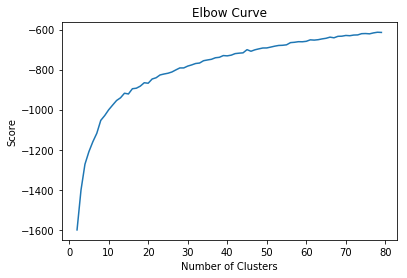

In [68]:
score = [kmeans[i].fit(X_scaled).score(X_scaled)/nFt for i in range(len(kmeans))]
plt.plot(lsNumK,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show() # k~5

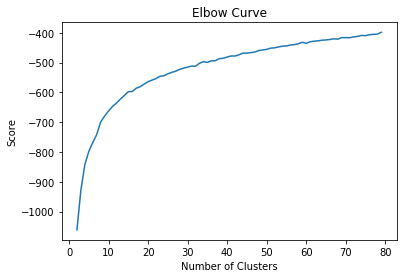

In [69]:
# Check score for pdfTest 
kmeans_y = [KMeans(n_clusters=i) for i in lsNumK]
score_y = [kmeans[i].fit(Y_scaled).score(Y_scaled)/nFt for i in range(len(kmeans_y))]
plt.plot(lsNumK,score_y)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [77]:
# 15 clusters
X_scaled = scaler.fit_transform(X)
kmeans_15 = kmeans_y[13]
X_cluster = kmeans_15.fit_predict(X_scaled)

In [75]:
len(kmeans_15.cluster_centers_)

15

In [76]:
X_cluster.shape

(30000,)

In [80]:
X_label = pdfTrain["label"].values
X_id = pdfTrain["id"].values
# X_full = np.append([X_cluster, X_label], axis=1)
pdfTrainCluster = pd.DataFrame({"id": X_id, "cluster":X_cluster, "label": X_label})

In [82]:
pdf01 = pdfTrainCluster.groupby(["cluster", "label"], as_index=False).agg({"id":"count"})
pdf01.head(30)

,cluster,label,id
0,0,0,884
1,0,1,6
2,1,0,4522
3,1,1,107
4,2,0,1497
5,2,1,35
6,3,0,1808
7,3,1,14
8,4,0,1825
9,4,1,25


In [92]:
pdf02 = pdf01.pivot(index="cluster", columns="label", values="id").rename_axis(None)
pdf02["ratio"] = pdf02[1]/pdf02[0]
pdf02.sort_values(["ratio"])

label,0,1
0,884,6
1,4522,107
2,1497,35
3,1808,14
4,1825,25


In [99]:
# Compare centroid for k_15 X and k_15 Y
kx_15 = KMeans(n_clusters=15).fit(X_scaled)
ky_15 = KMeans(n_clusters=15).fit(Y_scaled)


In [102]:
import numpy
import scipy
from itertools import product
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree as KDTree

In [112]:
a = kx_15.cluster_centers_
b = ky_15.cluster_centers_
# print(a, b)
t1 = KDTree(a)
t2 = KDTree(b)
maxD = 20 #numpy.linalg.norm(a[0] - b[0])
ans = t1.sparse_distance_matrix(t2, maxD)

In [117]:
lsPair = []
for i in range(15):
    minIdx = 0
    for j in range(1, 15):
        if ans[i, minIdx] > ans[i, j]:
            minIdx = j
    lsPair.append((i, minIdx, ans[i, minIdx]))
pprint(lsPair)

[(0, 5, 1.0877730469330875),
 (1, 0, 0.02519432282473113),
 (2, 4, 0.8235746347851594),
 (3, 5, 0.5802205650046597),
 (4, 6, 0.7513997327487524),
 (5, 9, 0.29945512042484423),
 (6, 13, 0.12651504908612826),
 (7, 10, 0.017135201137969434),
 (8, 1, 0.09885603995296703),
 (9, 2, 0.628220349146939),
 (10, 12, 0.0836314561751576),
 (11, 11, 1.2364232655865153),
 (12, 8, 0.4248150892541081),
 (13, 6, 1.0287715276519807),
 (14, 7, 0.5942650541413421)]


In [118]:
X_check = kx_15.predict(X_scaled)
X_check.shape

(30000,)

In [119]:
pdfTrainCheck = pd.DataFrame({"id": X_id, "cluster":X_check, "label": X_label})

In [120]:
pdf03 = pdfTrainCheck.groupby(["cluster", "label"], as_index=False).agg({"id":"count"})

In [124]:
pdfTrainCheck.shape, pdfTrainCluster.shape

((30000, 3), (30000, 3))

In [123]:
pdf03.shape, pdf01.shape

((30, 3), (30, 3))

In [121]:
pdf04 = pdf03.pivot(index="cluster", columns="label", values="id").rename_axis(None)
pdf04["ratio"] = pdf04[1]/pdf04[0]
pdf04.sort_values(["ratio"])

label,0,1,ratio
11,1179,8,0.006785
8,1469,12,0.008169
3,2460,21,0.008537
12,2146,20,0.009320
0,1176,11,0.009354
2,1057,10,0.009461
5,2062,22,0.010669
9,1748,20,0.011442
7,4863,93,0.019124
4,1029,22,0.021380


In [122]:
pdf02.sort_values(["ratio"])

label,0,1,ratio
0,884,6,0.006787
5,1436,11,0.007660
3,1808,14,0.007743
10,1551,13,0.008382
12,1973,21,0.010644
9,1475,16,0.010847
7,2342,28,0.011956
4,1825,25,0.013699
14,1707,28,0.016403
11,1175,20,0.017021


### Add neighbor features
Neighbor features: 
    + avg+std of groupby (province, age_group, maCv)
    + avg+std of groupby (lv3_loc, age_group, maCv)
    + avg+std of groupby (province, maCv)
    

In [165]:
aggDict = {}
for f in lsFieldFt:
    aggDict[f] = ["mean", "std"]

In [166]:
# 1
lsMetaCol1 = ["province", "group_age", "jobCat"]
lsMetaCol2 = ["lv3_loc", "group_age", "jobCat"]
lsMetaCol3 = ["province", "jobCat"]

In [ ]:
dfNb01 = pdfTrain.groupby(lsMetaCol1, as_index=False).agg(aggDict)
dfNb01.columns = ["_".join(x) for x in dfNb01.columns.ravel()]
dfNb01 = dfNb01.rename(columns={"province_": "province", 
                       "group_age_": "group_age", 
                       "jobCat_": "jobCat"})
printRuntime()

In [ ]:
dfNb02 = pdfTrain.groupby(lsMetaCol2, as_index=False).agg(aggDict)
dfNb02.columns = ["_".join(x) for x in dfNb02.columns.ravel()]
dfNb02 = dfNb02.rename(columns={"province_": "province", 
                       "group_age_": "group_age", 
                       "jobCat_": "jobCat"})
printRuntime()

In [ ]:
dfNb03 = pdfTrain.groupby(lsMetaCol3, as_index=False).agg(aggDict)
dfNb03.columns = ["_".join(x) for x in dfNb03.columns.ravel()]
dfNb03 = dfNb03.rename(columns={"province_": "province", 
                       "group_age_": "group_age", 
                       "jobCat_": "jobCat"})
printRuntime()

In [ ]:
# Save outputs: pdfTrain, dfNb01, dfNb02, dfNb03
pdfTrain.to_pickle(cleanedTrain, compression="bz2")
pdfTest.to_pickle(cleanedTest, compression="bz2")
dfNb01.to_pickle(nb01, compression="bz2")
dfNb02.to_pickle(nb02, compression="bz2")
dfNb03.to_pickle(nb03, compression="bz2")
printRuntime()

In [ ]:
dfNb01.head()

### raw ft + nb ft + standardize raw ft

In [173]:
lsMetaCol = ["id", "label", "province", "district", "lv3_loc", 
              "age_source1", "age_source2", "avg_age", "diff_age", "group_age",
              "maCv", "jobCat", "jobDesc"]
lsEmbedFt = ["FIELD_%d"%d for d in [7, 9, 13, 39]]
lsCol = [8, 10, 12, 17, 24, 40, 43] # For target encoding
lsMeanEncodCol = ["FIELD_%d"%d for d in lsCol] + ["group_age"]
# raw ft
lsFieldFt = ([c for c in pdfTrain.columns 
             if "FIELD" in c 
             and c not in lsEmbedFt and c not in lsMeanEncodCol]
#              + lsExtraFt
            )

label = "label"
printRuntime()

2020-02-17 15:33:36
-------------------


In [174]:
# nb ft
lsNbMetaCol = lsMetaCol1
dfNb = dfNb01 # TODO: dfNb02, dfNb03
printRuntime()

2020-02-17 15:33:38
-------------------


In [175]:
dfITrain = pd.merge(pdfTrain, dfNb01, on=lsNbMetaCol, how="left")

print(dfITrain.shape)
printRuntime()

(30000, 331)
2020-02-17 15:33:42
-------------------


In [176]:
lsTmp = [c for c in dfITrain.columns if c not in lsFieldFt]
# pprint(lsTmp)

In [177]:
dfITrain.columns

Index(['id', 'label', 'province', 'district', 'age_source1', 'age_source2',
       'maCv', 'FIELD_1', 'FIELD_2', 'FIELD_3',
       ...
       'FIELD_AGE_3_mean', 'FIELD_AGE_3_std', 'FIELD_AGE_4_mean',
       'FIELD_AGE_4_std', 'FIELD_AGE_NONE_mean', 'FIELD_AGE_NONE_std',
       'FIELD_group_age_ecdmean_mean', 'FIELD_group_age_ecdmean_std',
       'FIELD_group_age_ecdstd_mean', 'FIELD_group_age_ecdstd_std'],
      dtype='object', length=331)

In [178]:
dfITrain.head()

,id,label,province,district,age_source1,age_source2,maCv,FIELD_1,FIELD_2,FIELD_3,...,FIELD_AGE_3_mean,FIELD_AGE_3_std,FIELD_AGE_4_mean,FIELD_AGE_4_std,FIELD_AGE_NONE_mean,FIELD_AGE_NONE_std,FIELD_group_age_ecdmean_mean,FIELD_group_age_ecdmean_std,FIELD_group_age_ecdstd_mean,FIELD_group_age_ecdstd_std
0,0,0,nan,nan,NaN,NaN,none,1.0,1.0,2547.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.019980,0.0,0.139941,0.0
1,1,0,tỉnh đồng nai,thành phố biên hòa,44,44,none,1.0,0.0,-1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.016651,0.0,0.127971,0.0
2,2,0,tỉnh đồng nai,huyện long thành,30,30,công nhân,0.0,1.0,3273.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.013346,0.0,0.114758,0.0
3,3,0,tỉnh tuyên quang,thành phố tuyên quang,43,NaN,none,0.0,1.0,3991.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.016651,0.0,0.127971,0.0
4,4,0,thành phố hồ chí minh,quận 1,21,21,none,0.0,1.0,1450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.014498,0.0,0.119550,0.0


In [179]:
for c in lsFieldFt:
    dfITrain["%s_stdized"%c] = (dfITrain[c] - dfITrain[c+"_mean"])/dfITrain[c+"_std"]
print(dfITrain.shape) # (29924, 353)
printRuntime()

(30000, 423)
2020-02-17 15:33:48
-------------------


In [180]:
ymd = datetime.datetime.now().strftime("%Y%m%d")
iTrainPath = basePath + "itrain_{}.pickle".format(ymd)
print(iTrainPath)
dfITrain.to_pickle(iTrainPath, compression="bz2")
printRuntime()

./kalapa/itrain_20200217.pickle
2020-02-17 15:34:02
-------------------


In [181]:
dfITrain.head()

,id,label,province,district,age_source1,age_source2,maCv,FIELD_1,FIELD_2,FIELD_3,...,FIELD_9_APPEAR_stdized,FIELD_9_INDEX_stdized,FIELD_avg_age_stdized,FIELD_diff_age_stdized,FIELD_AGE_0_stdized,FIELD_AGE_1_stdized,FIELD_AGE_2_stdized,FIELD_AGE_3_stdized,FIELD_AGE_4_stdized,FIELD_AGE_NONE_stdized
0,0,0,nan,nan,NaN,NaN,none,1.0,1.0,2547.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,tỉnh đồng nai,thành phố biên hòa,44,44,none,1.0,0.0,-1.0,...,0.637609,0.193968,0.228218,0.228218,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,tỉnh đồng nai,huyện long thành,30,30,công nhân,0.0,1.0,3273.0,...,0.664303,0.202861,0.150470,0.150470,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,tỉnh tuyên quang,thành phố tuyên quang,43,NaN,none,0.0,1.0,3991.0,...,-1.306296,-0.957427,0.593771,0.593771,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,thành phố hồ chí minh,quận 1,21,21,none,0.0,1.0,1450.0,...,0.591361,1.803420,-0.710923,-0.710923,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare itest

In [182]:
lsNbMetaCol

['province', 'group_age', 'jobCat']

In [183]:
pdfTest.columns

Index(['id', 'province', 'district', 'age_source1', 'age_source2', 'maCv',
       'FIELD_1', 'FIELD_2', 'FIELD_3', 'FIELD_4',
       ...
       'FIELD_avg_age', 'FIELD_diff_age', 'group_age', 'FIELD_AGE_0',
       'FIELD_AGE_1', 'FIELD_AGE_2', 'FIELD_AGE_3', 'FIELD_AGE_4',
       'FIELD_AGE_NONE', 'lv3_loc'],
      dtype='object', length=114)

In [184]:
dfITest = pd.merge(pdfTest, dfNb01, on=lsNbMetaCol, how="left")

In [185]:
dfITest.shape # label col is missing

(20000, 330)

In [186]:
lsTmp = [c for c in dfITest.columns if c not in lsFieldFt]
# pprint(lsTmp)

In [187]:
dfITest.head()

,id,province,district,age_source1,age_source2,maCv,FIELD_1,FIELD_2,FIELD_3,FIELD_4,...,FIELD_AGE_3_mean,FIELD_AGE_3_std,FIELD_AGE_4_mean,FIELD_AGE_4_std,FIELD_AGE_NONE_mean,FIELD_AGE_NONE_std,FIELD_group_age_ecdmean_mean,FIELD_group_age_ecdmean_std,FIELD_group_age_ecdstd_mean,FIELD_group_age_ecdstd_std
0,30000,nan,nan,NaN,NaN,none,1.0,1.0,719.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.019980,0.0,0.139941,0.0
1,30001,nan,nan,NaN,NaN,none,1.0,1.0,1442.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.019980,0.0,0.139941,0.0
2,30002,thành phố hà nội,huyện mỹ đức,32,32,trưởng dây chuyền phòng sản xuất,0.0,1.0,4000.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30003,nan,nan,NaN,25,none,0.0,1.0,1073.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.013346,0.0,0.114758,0.0
4,30004,nan,nan,NaN,NaN,none,1.0,1.0,703.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.019980,0.0,0.139941,0.0


In [188]:
for c in lsFieldFt:
    dfITest["%s_stdized"%c] = (dfITest[c] - dfITest[c+"_mean"])/dfITest[c+"_std"]
print(dfITest.shape) # (19936, 340)
printRuntime()

(20000, 422)
2020-02-17 15:34:03
-------------------


In [189]:
iTestPath = basePath + "itest_{}.pickle".format(ymd)
dfITest.to_pickle(iTestPath, compression="bz2")
printRuntime()

2020-02-17 15:34:12
-------------------


In [65]:
dfITest.head()

,id,label,province,district,age_source1,age_source2,maCv,FIELD_1,FIELD_2,FIELD_3,...,FIELD_24_K2_stdized,FIELD_24_K3_stdized,FIELD_24_None_stdized,FIELD_43_0_stdized,FIELD_43_5_stdized,FIELD_43_A_stdized,FIELD_43_B_stdized,FIELD_43_C_stdized,FIELD_43_D_stdized,FIELD_43_None_stdized
0,0,0,NaN,NaN,NaN,NaN,nan,1.0,1.0,2547.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,Tỉnh Đồng Nai,Thành phố Biên Hòa,44.0,44.0,none,1.0,0.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.224257,NaN,0.224257
2,2,0,Tỉnh Đồng Nai,Huyện Long Thành,30.0,30.0,công nhân,0.0,1.0,3273.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.223014,-0.126664,0.259688
3,3,0,Tỉnh Tuyên Quang,Thành phố Tuyên Quang,43.0,NaN,nan,0.0,1.0,3991.0,...,-0.288675,NaN,0.288675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,Thành phố Hồ Chí Minh,Quận 1,21.0,21.0,none,0.0,1.0,1450.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
for c in dfITest.columns:
    print(c)

id
province
district
age_source1
age_source2
maCv
FIELD_1
FIELD_2
FIELD_3
FIELD_4
FIELD_5
FIELD_6
FIELD_7
FIELD_9
FIELD_11
FIELD_13
FIELD_14
FIELD_15
FIELD_16
FIELD_18
FIELD_19
FIELD_20
FIELD_21
FIELD_22
FIELD_23
FIELD_25
FIELD_26
FIELD_27
FIELD_28
FIELD_29
FIELD_30
FIELD_31
FIELD_32
FIELD_33
FIELD_34
FIELD_35
FIELD_36
FIELD_37
FIELD_38
FIELD_39
FIELD_41
FIELD_42
FIELD_44
FIELD_45
FIELD_46
FIELD_47
FIELD_48
FIELD_49
FIELD_50
FIELD_51
FIELD_52
FIELD_53
FIELD_54
FIELD_55
FIELD_56
FIELD_57
maCv_vector
jobCat
jobDesc
FIELD_8_FEMALE
FIELD_8_MALE
FIELD_8_None
FIELD_10_GH
FIELD_10_None
FIELD_10_T1
FIELD_12_0
FIELD_12_1
FIELD_12_None
FIELD_17_G3
FIELD_17_G4
FIELD_17_G7
FIELD_17_G8
FIELD_17_G9
FIELD_17_GX
FIELD_17_None
FIELD_24_K1
FIELD_24_K2
FIELD_24_K3
FIELD_24_None
FIELD_40_02 05 08 11
FIELD_40_1
FIELD_40_2
FIELD_40_3
FIELD_40_6
FIELD_40_None
FIELD_43_0
FIELD_43_5
FIELD_43_A
FIELD_43_B
FIELD_43_C
FIELD_43_D
FIELD_43_None
FIELD_8_ecdmean
FIELD_8_ecdstd
FIELD_10_ecdmean
FIELD_10_ecdstd
FIELD_1